## Read this first


### How to run code step by step

- Create initial ROI by using your mouse and press ENTER or SPACE
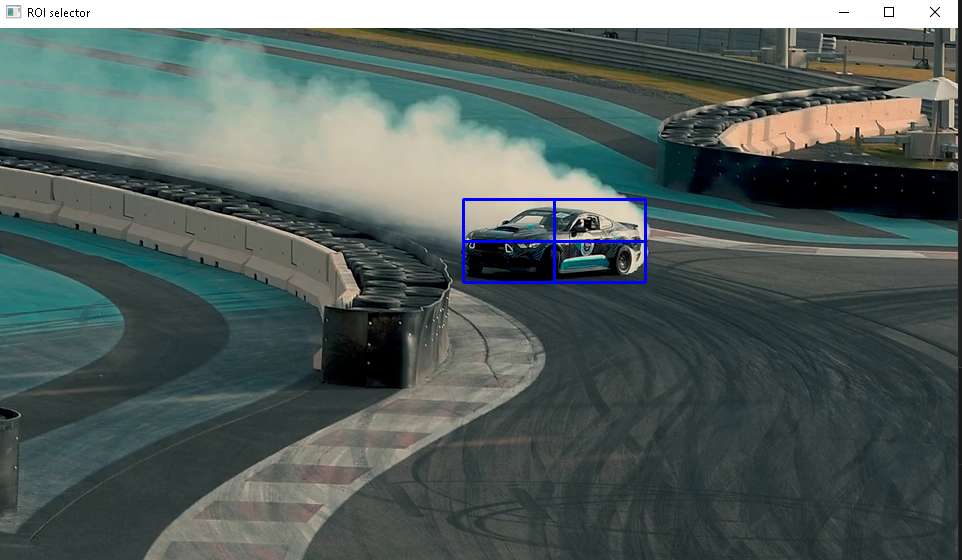

- Run code in SIFT + Kalman filter to test motion prediction
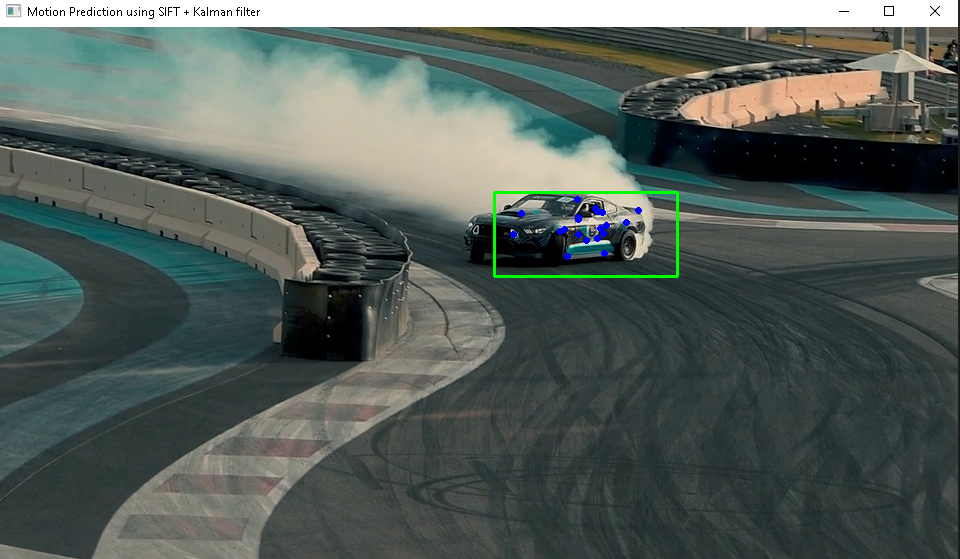

- There are 2 available videos with car and plane subject, you can test by creating ROI around them

Note: the performance is not great, please pick video below 5mb 

### SIFT + Kalman filter for motion prediction: explain step by step
- Based on initial ROI to get keypoints of object
- Loop through video frame by frame and do the following
	- Calculate keypoints of current frame
	- Use Brute Force or FLANN matcher to compare keypoints between current and previous frame
	- Sort and get the top matching keypoints based on "num_keypoint_matches" param (the less distance between 2 keypoints, the more similar it is to another)
	- Pass the top matching keypoints to Kalman filter, it will update x and y Position/Velocity/Acceleration based on average of all keypoints. The total number of keypoints used in this Kalman filter will depend on "ACCPTED_KEYPOINT_MATCHES" param
	- Draw circle and rectangle based on updated x and y postition


## Source Code

### Utils 

In [8]:
# Import necessary libraries
import cv2 
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import os
import time

In [9]:
def initialize_kalman_filter(roi):
    """Initializes a Kalman Filter for object tracking.

    Returns:
        cv2.KalmanFilter: The initialized Kalman Filter object.
    """
    # Initialize the Kalman filter
    kalman = cv2.KalmanFilter(4, 2) #position x,y and velocity x,y
    kalman.measurementMatrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0]], np.float32)
    kalman.transitionMatrix = np.array([[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)
    kalman.processNoiseCov =1*np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]], np.float32)

    
    # Initialize the Kalman filter state
    x, y, w, h = roi
    return kalman

def kalman_update_and_predict(kalman,sorted_matches,keypoint,ACCPTED_KEYPOINT_MATCHES):
    if(len(sorted_matches)<ACCPTED_KEYPOINT_MATCHES):
        return kalman
    
    # Get the average distance between the keypoints
    avg_matched_x, avg_matched_y = 0, 0
    sorted_matches=sorted_matches[:ACCPTED_KEYPOINT_MATCHES]
    
    for match in sorted_matches:
        avg_matched_x += keypoint[match.trainIdx].pt[0]
        avg_matched_y += keypoint[match.trainIdx].pt[1]
    avg_matched_x /= ACCPTED_KEYPOINT_MATCHES
    avg_matched_y /= ACCPTED_KEYPOINT_MATCHES
    
    measured = np.array([[np.float32(avg_matched_x)], [np.float32(avg_matched_y)]])
    estimate=kalman.correct(measured)
    prediction = kalman.predict()
    print("Prediction: ",prediction)
    
    return prediction
    

### Create initial region of interest

In [10]:
video_path = "resources/car.mp4"
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()

if not ret:
	raise ValueError("Error reading video file.")

roi= cv2.selectROI(frame)
print(roi)

x_min, y_min, w, h = roi
roi_image= frame[y_min:y_min+h, x_min:x_min+w]

# convert roi to grayscale, SIFT Algorithm works with grayscale images
roi_gray=cv2.cvtColor(roi_image,cv2.COLOR_BGR2GRAY) 
sift = cv2.SIFT_create(edgeThreshold=15,contrastThreshold=0.1)
keypoints_1, descriptors_1 = sift.detectAndCompute(roi_gray, None)
roi_keypoint_image=cv2.drawKeypoints(roi_gray,keypoints_1,roi_gray)

# visualize key points 
cv2.imshow("Frame", roi_keypoint_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


(467, 170, 183, 81)


### Motion prediction using SIFT + Kalman filter

In [11]:

cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
num_keypoint_matches=20
sift = cv2.SIFT_create(edgeThreshold=15,contrastThreshold=0.1)
kalman = initialize_kalman_filter(roi)

if not ret:
	raise ValueError("Error reading video file.")

while True:
    ret, frame = cap.read()
    # read the next frame from the video
    
    frame_gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    keypoints_2, descriptors_2 = sift.detectAndCompute(frame_gray, None)
    
    # Create a FLANN-based matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50) 
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    num_neighbours = 10
    flann_matches = flann.knnMatch(descriptors_1, descriptors_2, k=num_neighbours)
    flann_matches = [flann_matches[i][0] for i in range(len(flann_matches)) if len(flann_matches[i])>1]


    # Brute force matcher
    # bf=cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    # bf_matches =bf.match(descriptors_1, descriptors_2)
    
    matches = sorted(flann_matches, key = lambda x:x.distance)
    matches=matches[:num_keypoint_matches]
    
    
    # Predict the object's position using Kalman Filter.
    ACCPTED_KEYPOINT_MATCHES=10
    prediction=kalman_update_and_predict(kalman,matches,keypoints_2,ACCPTED_KEYPOINT_MATCHES)
        
    # Draw the predicted bounding box
    center_x, center_y = prediction[0], prediction[1]
    x1 = int(center_x - w / 2)
    y1 = int(center_y - h / 2)
    x2 = int(center_x + w / 2)
    y2 = int(center_y + h / 2)
    
    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
 
    matched_kp_current_frame=[keypoints_2[match.trainIdx].pt for match in matches]

    for m in matched_kp_current_frame:
        cv2.circle(frame,(int(m[0]),int(m[1])),2,(255,0,0),2)
        

    # play the video frame by frame
    cv2.imshow("Motion Prediction using SIFT + Kalman filter", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.destroyAllWindows()
        break

Prediction:  [[0.]
 [0.]
 [0.]
 [0.]]
Prediction:  [[293.08514]
 [102.5939 ]
 [  0.     ]
 [  0.     ]]
Prediction:  [[590.24304]
 [200.10341]
 [ 84.90226]
 [ 27.85986]]


C:\Users\Admin\AppData\Local\Temp\ipykernel_18776\1673712165.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1 = int(center_x - w / 2)
C:\Users\Admin\AppData\Local\Temp\ipykernel_18776\1673712165.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = int(center_y - h / 2)
C:\Users\Admin\AppData\Local\Temp\ipykernel_18776\1673712165.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x2 = int(center_x + w / 2)
C:\Users\Admin\AppData\Local\Temp\ipykernel_18

Prediction:  [[672.3389 ]
 [244.95836]
 [ 83.96681]
 [ 33.52489]]
Prediction:  [[660.76935 ]
 [234.48268 ]
 [ 51.588375]
 [ 18.61256 ]]
Prediction:  [[589.4188  ]
 [221.0751  ]
 [  9.87696 ]
 [  7.748585]]
Prediction:  [[574.9445   ]
 [210.81573  ]
 [  1.6146415]
 [  1.6385298]]
Prediction:  [[5.8653882e+02]
 [2.0779556e+02]
 [5.0008106e+00]
 [5.7800654e-02]]
Prediction:  [[565.8971   ]
 [203.4985   ]
 [ -3.7000327]
 [ -1.4198576]]
Prediction:  [[567.4499   ]
 [211.70657  ]
 [ -1.917676 ]
 [  1.8470299]]
Prediction:  [[ 5.8739520e+02]
 [ 2.0670714e+02]
 [ 5.5007353e+00]
 [-4.7607169e-01]]
Prediction:  [[567.8669   ]
 [199.78513  ]
 [ -2.9919732]
 [ -2.6632736]]
Prediction:  [[571.1547    ]
 [202.1755    ]
 [ -0.8611578 ]
 [ -0.94849944]]
Prediction:  [[583.1076   ]
 [206.68532  ]
 [  3.4868274]
 [  0.9035857]]
Prediction:  [[590.08606  ]
 [202.09726  ]
 [  4.67159  ]
 [ -0.9598025]]
Prediction:  [[ 5.8991656e+02]
 [ 2.0337138e+02]
 [ 3.0289357e+00]
 [-2.0180456e-01]]
Prediction:  [[566

### Result
- The result is great for small video'size (under 5mb)
- It depends a lot on initial keypoints extracted from ROI, so set "edgeThreshold" and "contrastThreshold" carefully in cv2.SIFT_create() to achive the best result
- For object that does not stand out from its enviroment background, the algorithm works not so well compare to more modern approach like machine learning, deep learning
